## The Project

The goals / steps of this project are the following:


* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


Here are links to the labeled data for vehicle and non-vehicle examples to train your classifier. These example images come from a combination of the GTI vehicle image database, the KITTI vision benchmark suite, and examples extracted from the project video itself. You are welcome and encouraged to take advantage of the recently released Udacity labeled dataset to augment your training data.

Some example images for testing your pipeline on single frames are located in the test_images folder. To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called ouput_images, and include them in your writeup for the project by describing what each image shows. The video called project_video.mp4 is the video your pipeline should work well on.

As an optional challenge Once you have a working pipeline for vehicle detection, add in your lane-finding algorithm from the last project to do simultaneous lane-finding and vehicle detection!

If you're feeling ambitious (also totally optional though), don't stop there! We encourage you to go out and take video of your own, and show us how you would implement this project on a new video!

In [108]:
import glob, pickle, cv2, glob, pickle, os
import numpy as np
import tracker
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from moviepy.editor import VideoFileClip

In [109]:
class PerspectiveTransform:
    def __init__(self):

        self.ret = None
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs= None
        
        OFFSET = 130
        SRC = np.float32([  (30, 703),
                            (540, 466),
                            (720, 466),
                            (1147, 703)])

        DST = np.float32([  (SRC[0][0] + OFFSET, 720),
                            (SRC[0][0] + OFFSET, 0),
                            (SRC[-1][0] - OFFSET, 0),
                            (SRC[-1][0] - OFFSET, 720)])
        
        self.get_camera_calibration()
        self.M = cv2.getPerspectiveTransform(SRC, DST)
        self.Minv = cv2.getPerspectiveTransform(SRC, DST)

    def get_camera_calibration(self):
        ROWS, COLUMNS = 9, 6
        # prepare object points and image points from images
        objp = np.zeros((COLUMNS*ROWS,3), np.float32)
        objp[:,:2] = np.mgrid[0:ROWS, 0:COLUMNS].T.reshape(-1, 2)

        objpoints = []
        imgpoints = []

        calibration_images = glob.glob('./camera_cal/calibration*.jpg')

        for index, filename in enumerate(calibration_images):
            img = cv2.imread(filename)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
            # find corners
            ret, corners = cv2.findChessboardCorners(gray, (ROWS,COLUMNS),None)
    
            # find object and image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
        
                #display corners
                cv2.drawChessboardCorners(img, (ROWS, COLUMNS), corners, ret)
                write_name = './output_images/corners_found'+str(index)+'.jpg'
                cv2.imwrite(write_name, img)
        
        img = cv2.imread('./camera_cal/calibration1.jpg')
        img_size = (img.shape[0], img.shape[1])

        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        
    def warp(self, img):
        return cv2.warpPerspective(img, self.M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    def inverse_warp(self, img):
        return cv2.warpPerspective(img, self.Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
    
    def get_histogram(self, img):
        return np.sum(img[int(img.shape[0]/2):,:], axis=0)
    
    def generate_binary(self, img):
        ksize = 3
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]

        # Grayscale image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        thresh_min = 70
        thresh_max = 100
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Threshold color channel
        s_thresh_min = 180
        s_thresh_max = 255
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        # Stack each channel to view their individual contributions in green and blue respectively
        # This returns a stack of the two binary images, whose components you can see as different colors
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
        return combined_binary

image = cv2.imread('./camera_cal/calibration1.jpg')

transformer = PerspectiveTransform()
undistorted = transformer.undistort(image)

In [110]:
# Define a class to receive the characteristics of each line detection
class SVC_Classifier:
    def __init__(self, car_file_path, non_car_file_path):
        self.car_images = None
        self.non_car_images = None
        self.car_features = None
        self.non_car_features = None
        
        self.ystart = 380
        self.ystop = 656
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        
        self.y = None            
        self.X = None            
        self.scaled_X = None
        self.X_scaler = None
        self.SVC = None
        
        self.set_image_paths(car_file_path, non_car_file_path)
        self.load_classifier()
        
    def set_image_paths(self, car_file_path, non_car_file_path):
        # read test images int
        self.car_images = []
        self.non_car_images = []
        
        # add cars to list
        directory_paths = []
        indir=os.listdir(car_file_path)
        for image_path in indir:
            if (image_path != ".DS_Store"):
                directory_paths.append(car_file_path+image_path)
        
        for path in directory_paths:
            indir=os.listdir(path)
            indir.sort()
            for image_path in indir:
                full_path = path + '/' + image_path
                image = cv2.imread(full_path)
                self.car_images.append(image)
        
        # add non-cars to list
        directory_paths = []
        indir=os.listdir(non_car_file_path)
        for image_path in indir:
            if image_path != '.DS_Store':
                directory_paths.append(non_car_file_path+image_path)
        
        for path in directory_paths:
            indir=os.listdir(path)
            indir.sort()
            for image_path in indir:
                full_path = path + '/' + image_path
                image = cv2.imread(full_path)
                self.non_car_images.append(image)
                 
    def bin_spatial(self, img, size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features
 
    def color_hist(self, img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features

    # Define a function to return HOG features and visualization
    def get_hog_features(self, img, vis=False, feature_vec=True):
        
        if vis == True:
            features, hog_image = hog(img, orientations=self.orient, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                  cells_per_block=(self.cell_per_block, self.cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
            return features, hog_image
        else:      
            features = hog(img, orientations=self.orient, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                       cells_per_block=(self.cell_per_block, self.cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
            
            return features 
    
    def extract_image_features(self, image, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
        # apply color conversion if other than 'BGR'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = self.bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = self.color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Get HOG features
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(self.get_hog_features(feature_image[:,:,channel]))
        hog_features = np.ravel(hog_features) 
        # Append the new feature vector to the features list
        retval = np.concatenate((spatial_features, hist_features, hog_features))
        return retval
        
    def extract_features(self, imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for image in imgs:
            img_features = self.extract_image_features(image, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
            features.append(img_features)
        # Return list of feature vectors
        return features

    def combine_and_normalize(self):
        if len(self.car_features) > 0:
            self.y = np.hstack((np.ones(len(self.car_features)), np.zeros(len(self.non_car_features))))    
            # Create an array stack of feature vectors
            print
            self.X = np.vstack((self.car_features, self.non_car_features)).astype(np.float64)                        
            # Fit a per-column scaler
            self.X_scaler = StandardScaler().fit(self.X)
            # Apply the scaler to X
            self.scaled_X = self.X_scaler.transform(self.X)
        return
        
    def save_classifier(self):
        # save the classifier
        #joblib.dump(self.SVC, 'SVC-Classifier.pkl')
        print("Saving Classifier...")
        svc_bin = {"svc": self.SVC, "scaler": self.X_scaler}
        pickle.dump(svc_bin, open("svc_pickle.p", "wb"))
        print("Classifier Saved.")  
            
    def load_classifier(self):
        if os.path.isfile('svc_pickle.p'):
            print("Loading Classifier...")
            # load it again
            #self.SVC = joblib.load('SVC-Classifier.pkl')
            
            dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
            self.SVC = dist_pickle["svc"]
            self.X_scaler = dist_pickle["scaler"]
            print("Classifier Loaded.")            
        else:
            print("No preprocessed classifier available yet. Preprocessing ...")
            self.preprocess()
            print("Preprocessing completed.")
                 
    def train(self):
        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(self.scaled_X, self.y, test_size=0.1, random_state=rand_state)
        
        print('Using:',32,'orientations',32, 'pixels per cell and', 2,'cells per block')
        print('Feature vector length:', len(X_train[0]))
        # Use a linear SVC 
        self.SVC = LinearSVC()
        # Check the training time for the SVC
        import time
        t=time.time()
        self.SVC.fit(X_train, y_train)
        t2 = time.time()
        self.save_classifier()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(self.SVC.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 100
        print('My SVC predicts: ', self.SVC.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')  
        
    def preprocess(self):
        self.car_features = self.extract_features(self.car_images)
        self.non_car_features = self.extract_features(self.non_car_images)
        self.combine_and_normalize()
        self.train()
        
    def predict_image(self, img):
        if self.X_scaler is not None:
            img=cv2.resize(img, (64, 64), interpolation=cv2.INTER_NEAREST)
            features = self.extract_image_features(img)
            features = self.X_scaler.transform(np.array(features).reshape(1, -1))
            return self.SVC.predict(features) 
        else:
            print("No SVC or X_scaler loaded/trained yet.")
    
    def convert_color(self, img, conv='RGB2YCrCb'):
        if conv == 'RGB2YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        if conv == 'RGB2YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        if conv == 'RGB2LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
    def find_cars_deprecated(self, img, scale=1.5):
                
        draw_img = np.copy(img)
    
        img_tosearch = img[self.ystart:self.ystop,:,:]
        ctrans_tosearch = self.convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1.0:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        img = ctrans_tosearch

        # Define blocks and steps as above
        nxblocks = (img.shape[1] // self.pix_per_cell)-1
        nyblocks = (img.shape[0] // self.pix_per_cell)-1 
        nfeat_per_block = self.orient*self.cell_per_block**2
        
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // self.pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step  
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                xleft = xpos*self.pix_per_cell
                ytop = ypos*self.pix_per_cell
                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                                
                test_prediction = self.predict(subimg)            
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+self.ystart),(xbox_left+win_draw,ytop_draw+win_draw+self.ystart),(0,0,255),6) 
                
        return draw_img
    
    def find_cars(self, img, scale=1.5):
        draw_img = np.copy(img)
        #img = img.astype(np.float32) / 255
        
        img_tosearch = img[self.ystart:self.ystop, :, :]
        ctrans_tosearch = self.convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
        
        ch1 = ctrans_tosearch[:, :, 0]
        ch2 = ctrans_tosearch[:, :, 1]
        ch3 = ctrans_tosearch[:, :, 2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // self.pix_per_cell) - 1
        nyblocks = (ch1.shape[0] // self.pix_per_cell) - 1
        nfeat_per_block = self.orient * self.cell_per_block ** 2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // self.pix_per_cell) - 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = self.get_hog_features(ch1, feature_vec=False)
        hog2 = self.get_hog_features(ch2, feature_vec=False)
        hog3 = self.get_hog_features(ch3, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos * self.pix_per_cell
                ytop = ypos * self.pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

                # Get color features
                spatial_features = self.bin_spatial(subimg)
                hist_features = self.color_hist(subimg)

                # Scale features and make a prediction
                test_features = self.X_scaler.transform(
                    np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
                test_prediction = self.SVC.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft * scale)
                    ytop_draw = np.int(ytop * scale)
                    win_draw = np.int(window * scale)
                    cv2.rectangle(draw_img, (xbox_left, ytop_draw + self.ystart), (xbox_left + win_draw, ytop_draw + win_draw + self.ystart), (0, 0, 255), 6)

                
                    
        return draw_img

In [111]:
classifier = SVC_Classifier('./vehicles/', './non-vehicles/')

Loading Classifier...
Classifier Loaded.


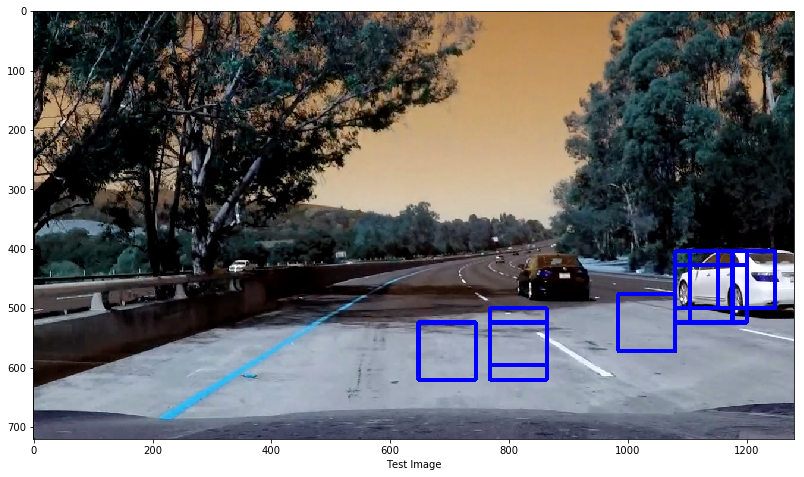

In [112]:
image = cv2.imread('./test_images/test5.jpg')
out_img = classifier.find_cars(image, scale=1.5)

plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.hold(True)
plt.imshow(out_img)      
plt.xlabel('Test Image')  

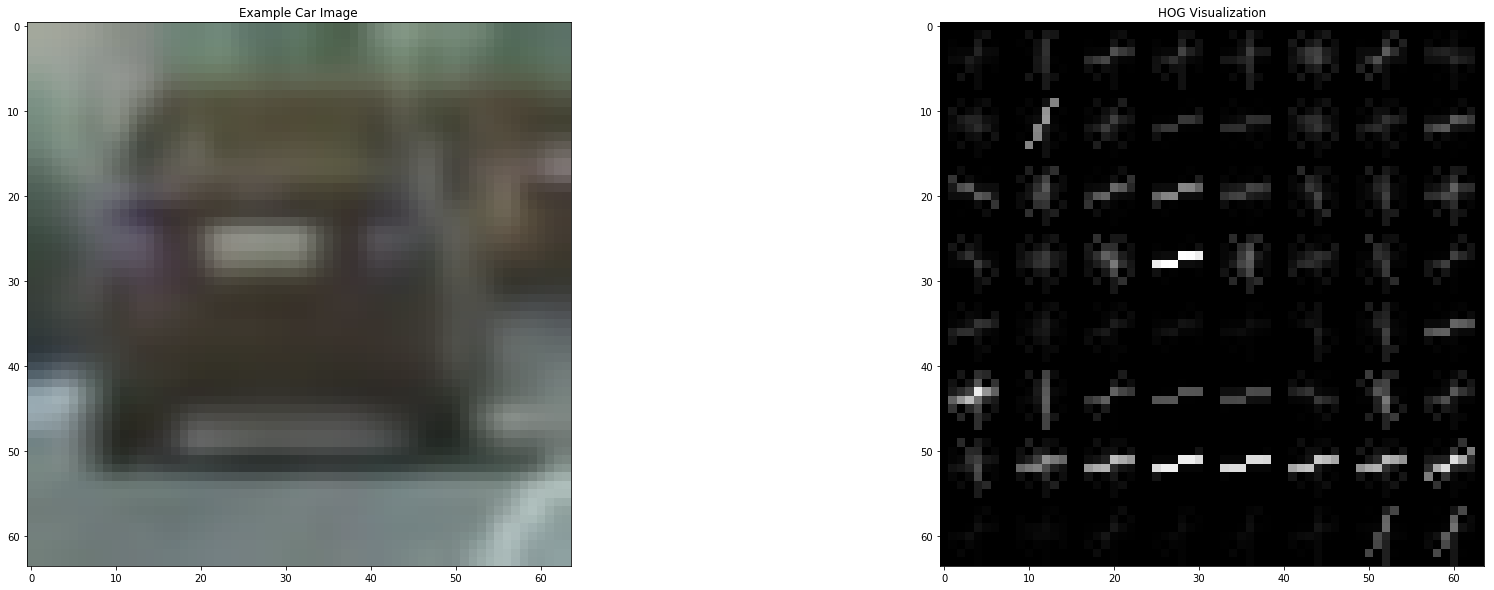

In [102]:
image = cv2.imread('./vehicles/GTI_Far/image0000.png')  
images = []
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

features, hog_image = classifier.get_hog_features(gray, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(30,10))
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [ ]:
classifier.preprocess()

In [103]:
img = cv2.imread('./vehicles/GTI_MiddleClose/image0000.png')

result = classifier.predict_image(img)
if result[0] == 1.0:
    answer = 'a car'
else:
    answer = 'no car'
print("My prediction: This image is: ", answer)

My prediction: This image is:  a car


In [104]:
img = cv2.imread('./test_images/test63.jpg')

result = classifier.predict_image(img)
if result[0] == 1.0:
    answer = 'a car'
else:
    answer = 'no car'
print("My prediction: This image is: ", answer)

My prediction: This image is:  a car


## Sliding window search

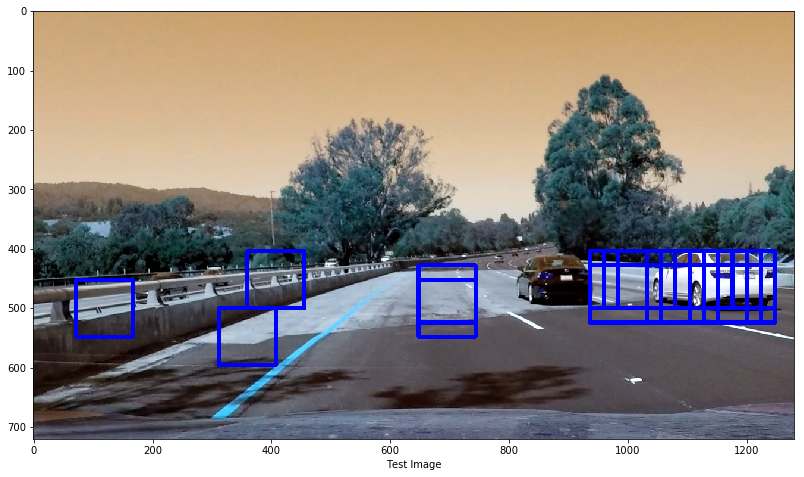

In [114]:
image = cv2.imread('./test_images/test4.jpg')
out_img = classifier.find_cars(image)

plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.hold(True)
plt.imshow(out_img)      
plt.xlabel('Test Image')     